In [13]:
!pip install pyarrow

In [83]:
!pip install mrjob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 11.5 MB/s eta 0:00:0000:01


### Скрипт для создания input файла

In [78]:
input_file = '/kaggle/working/input.txt'

filelist = ['/kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt',
            '/kaggle/input/star-wars-movie-scripts/SW_EpisodeV.txt',
            '/kaggle/input/star-wars-movie-scripts/SW_EpisodeVI.txt']

with open(input_file, 'w') as f:
    f.write('')
    
for file_name in filelist:
    with open(file_name) as f:
        input_data = f.read()
    with open(input_file, 'a') as f:
        f.write(input_data) 

# Задача 1: Болтун - находка для шпиона империи!

### Демонстрация подсчета кол-ва фраз по персонажам

In [14]:
from pyarrow import fs

In [23]:
with hdfs.open_output_stream("SW_EpisodeIV.txt") as file:
    data = file.readall().decode("utf-8")

In [61]:
with open('/kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt') as file:
    data = file.read()

In [67]:
lines = [line for line in data.split('\n')]
print('\n'.join(lines[0:5]))

"character" "dialogue"
"1" "THREEPIO" "Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!"
"2" "THREEPIO" "We're doomed!"
"3" "THREEPIO" "There'll be no escape for the Princess this time."
"4" "THREEPIO" "What's that?"


In [72]:
map_chars = dict()

for line in lines:
    input_list = line.split('" "')
    if len(input_list) == 3:
        char = input_list[1]
        if char in map_chars:
            map_chars[char] += 1
        else:
            map_chars[char] = 1

In [73]:
map_chars

{'THREEPIO': 119,
 'LUKE': 254,
 'IMPERIAL OFFICER': 2,
 'VADER': 41,
 'REBEL OFFICER': 1,
 'TROOPER': 19,
 'CHIEF PILOT': 1,
 'CAPTAIN': 1,
 'WOMAN': 1,
 'FIXER': 2,
 'CAMIE': 2,
 'BIGGS': 34,
 'DEAK': 1,
 'LEIA': 57,
 'COMMANDER': 3,
 'SECOND OFFICER': 1,
 'FIRST TROOPER': 6,
 'SECOND TROOPER': 3,
 'BERU': 1,
 'OWEN': 25,
 'AUNT BERU': 6,
 'BEN': 82,
 'TAGGE': 4,
 'MOTTI': 4,
 'TARKIN': 28,
 'BARTENDER': 3,
 'CREATURE': 1,
 'HUMAN': 4,
 'HAN': 153,
 'GREEDO': 6,
 'JABBA': 6,
 'OFFICER CASS': 1,
 'VOICE OVER DEATH STAR INTERCOM': 1,
 'OFFICER': 11,
 'VOICE': 3,
 'GANTRY OFFICER': 2,
 'INTERCOM VOICE': 6,
 'TROOPER VOICE': 1,
 'FIRST OFFICER': 1,
 'WILLARD': 2,
 'DEATH STAR INTERCOM VOICE': 6,
 'DODONNA': 6,
 'GOLD LEADER': 14,
 'WEDGE': 14,
 'MAN': 1,
 'RED LEADER': 37,
 'CHIEF': 2,
 'MASSASSI INTERCOM VOICE': 3,
 'RED TEN': 8,
 'RED SEVEN': 1,
 'PORKINS': 1,
 'RED NINE': 2,
 'RED ELEVEN': 1,
 'ASTRO-OFFICER': 1,
 'CONTROL OFFICER': 1,
 'GOLD FIVE': 7,
 'GOLD TWO': 2,
 'WINGMAN': 2,
 

### MapReduce

In [86]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob # import the mrjob library

class MRSongCount(MRJob):
    #В маппер приходят отдельные строки
    def mapper(self, _, line):
        map_chars = {}
        input_list = line.split('" "')
        if len(input_list) == 3:
            char = input_list[1]
            if char in map_chars:
                map_chars[char] += 1
            else:
                map_chars[char] = 1     
        for char, values in map_chars.items():
            yield (char, values)
    #На выходе у нас пары: (персонаж, кол-во фраз)
    # (LUKE, 250)
    # (HAN, 150)
    # и так далее

    #На выходе у нас пары: (персонаж, список всех значений, полученных на предыдущей стадии)
    # (LUKE, [250, 200])
    # (HAN, [150, 150, 100])
    # и так далее
    def reducer(self, char, values):
        yield (char, sum(values))
        
if __name__ == "__main__":
    MRSongCount.run()

Overwriting chars_phrases_count.py


In [87]:
!python3 chars_phrases_count.py /kaggle/working/input.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.085926.164913
Running step 1 of 1...
job output is in /tmp/chars_phrases_count.root.20231125.085926.164913/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.085926.164913/output...
"LIEUTENANT"	2
"LUKE"	494
"TRACKING OFFICER"	2
"TRENCH OFFICER"	3
"TROOPER VOICE"	1
"TROOPER"	19
"VADER"	140
"VEERS"	7
"VOICE OVER DEATH STAR INTERCOM"	1
"VOICE"	4
"WALKER PILOT #1"	1
"WEDGE"	33
"WILLARD"	2
"WINGMAN"	2
"WOMAN CONTROLLER"	1
"WOMAN"	1
"Y-WING PILOT"	1
"YODA"	49
"ZEV"	6
"LURE"	1
"MAN"	2
"MASSASSI INTERCOM VOICE"	3
"MEDICAL DROID"	2
"MON MOTHMA"	3
"MOTTI"	4
"NAVIGATOR"	1
"NEEDA"	5
"NINEDENINE"	6
"OFFICER CASS"	1
"OFFICER"	13
"OOLA"	1
"OPERATOR"	1
"OWEN"	25
"OZZEL"	5
"PIETT"	31
"PILOT #2"	1
"PILOT VOICE"	1
"PILOT"	2
"PILOTS"	1
"PORKINS"	1
"REBEL CAPTAIN"	1
"REBEL FIGHTER"	1
"REBEL OFFICER"	1
"REBEL PILOT"	3
"RED ELEVEN"	

### Добавляем combine стадию

In [140]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep
import re


class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        input_list = line.split('" "')
        if len(input_list) == 3:
            char = input_list[1]
            yield (char, 1)

    def combiner_count_words(self, char, counts):
        # optimization: sum the words we've seen so far
        yield (char, sum(counts))

    def reducer_count_words(self, char, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (sum(counts), char)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, char_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        yield max(char_count_pairs)

if __name__ == '__main__':
    MRMostUsedWord.run()

Overwriting chars_phrases_count.py


In [141]:
!python3 chars_phrases_count.py /kaggle/working/input.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.091639.619520
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.091639.619520/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.091639.619520/output...
494	"LUKE"
Removing temp directory /tmp/chars_phrases_count.root.20231125.091639.619520...


In [172]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep
import re


class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        input_list = line.split('" "')
        if len(input_list) == 3:
            char = input_list[1]
            yield (char, 1)

    def combiner_count_words(self, char, counts):
        # optimization: sum the words we've seen so far
        yield (char, sum(counts))

    def reducer_count_words(self, char, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (sum(counts), char)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, char_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        return sorted(char_count_pairs, reverse=True)[0:20]

if __name__ == '__main__':
    MRMostUsedWord.run()

Overwriting chars_phrases_count.py


In [175]:
!python3 chars_phrases_count.py /kaggle/working/input.txt > output_1.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.092944.423244
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.092944.423244/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.092944.423244/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.092944.423244...


### Диаграмма

In [196]:
with open('/kaggle/working/output_1.txt') as file:
    data = [line.rstrip() for line in file]

In [203]:
data_to_diag = dict()

for sample in data:
    value, char = sample.split('\t')
    data_to_diag[char] = int(value)

In [204]:
data_to_diag

{'"LUKE"': 494,
 '"HAN"': 459,
 '"THREEPIO"': 301,
 '"LEIA"': 227,
 '"VADER"': 140,
 '"BEN"': 115,
 '"LANDO"': 101,
 '"YODA"': 49,
 '"EMPEROR"': 44,
 '"RED LEADER"': 38,
 '"BIGGS"': 34,
 '"WEDGE"': 33,
 '"PIETT"': 31,
 '"TARKIN"': 28,
 '"JABBA"': 26,
 '"OWEN"': 25,
 '"CREATURE"': 22,
 '"TROOPER"': 19,
 '"GOLD LEADER"': 14,
 '"ACKBAR"': 14}

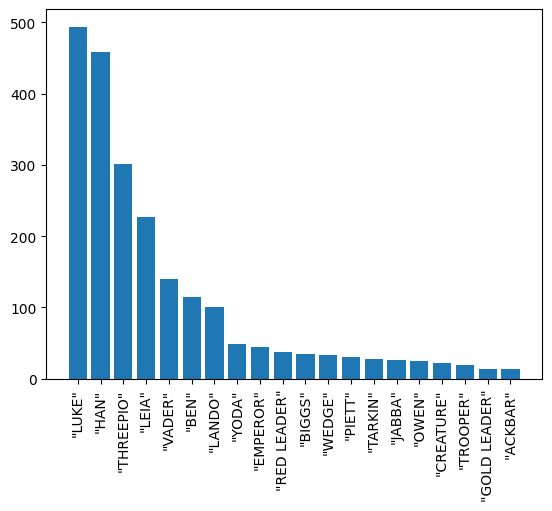

In [210]:
import matplotlib.pyplot as plt

plt.bar(x=data_to_diag.keys(), 
        height=data_to_diag.values(), 
        width=0.8)
plt.xticks(rotation=90);

# Задача 2: Воодушевляющая речь

### Демонстрация подсчета длины фразы

In [211]:
with open('/kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt') as file:
    data = file.read()

In [212]:
lines = [line for line in data.split('\n')]
print('\n'.join(lines[0:5]))

"character" "dialogue"
"1" "THREEPIO" "Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!"
"2" "THREEPIO" "We're doomed!"
"3" "THREEPIO" "There'll be no escape for the Princess this time."
"4" "THREEPIO" "What's that?"


In [219]:
map_phrases = dict()

for line in lines:
    input_list = line.split('" "')
    if len(input_list) == 3:
        char = input_list[1]
        phrase = input_list[2]
        if char in map_phrases:
            if len(phrase) > map_phrases[char][0]:
                map_phrases[char] = [len(phrase), phrase]
        else:
            map_phrases[char] = [len(phrase), phrase]

In [220]:
print('LUKE:', map_phrases['LUKE'])
print('HAN:', map_phrases['HAN'])
print('THREEPIO:', map_phrases['THREEPIO'])

LUKE: [319, '... so I cut off my power, shut down the afterburners and came in low on Deak\'s trail.  I was so close I thought I was going to fry my instruments. As it was I busted up the Skyhopper pretty bad.  Uncle Owen was pretty upset.  He grounded me for the rest of the season.  You should have been there... it was fantastic."']
HAN: [257, 'Kid, I\'ve flown from one side of this galaxy to the other.  I\'ve seen a lot of strange stuff, but I\'ve never seen anything to make me believe there\'s one all-powerful force controlling everything.  There\'s no mystical energy field that controls my destiny."']
THREEPIO: [289, 'He says he\'s the property of Obi-Wan Kenobi, a resident of these parts.  And it\'s a private message for him.  Quite frankly, sir, I don\'t know what he\'s talking about.  Our last master was Captain Antilles, but with what we\'ve been through, this little R2 unit has become a bit eccentric."']


### MapReduce

In [254]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob # import the mrjob library

class MRSongCount(MRJob):
    #В маппер приходят отдельные строки
    def mapper(self, _, line):
        map_chars = {}
        input_list = line.split('" "')
        if len(input_list) == 3:
            char = input_list[1]
            phrase = input_list[-1]
            if char in map_chars:
                if len(phrase) > map_chars[char]:
                    map_chars[char] = (len(phrase), phrase)
            else:
                map_chars[char] = (len(phrase), phrase)     
        for char, values in map_chars.items():
            yield (char, values)
    def reducer(self, char, values):
        yield (char, max(values))
        
if __name__ == "__main__":
    MRSongCount.run()

Overwriting chars_phrases_count.py


In [255]:
!python3 chars_phrases_count.py /kaggle/working/input.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.100820.992991
Running step 1 of 1...
job output is in /tmp/chars_phrases_count.root.20231125.100820.992991/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.100820.992991/output...
"LIEUTENANT"	[79,"Sir, all the patrols are in. There's still no contact from  Skywalker or Solo.\""]
"LUKE"	[503,"Greetings, Exalted One. Allow me to introduce myself. I am Luke Skywalker, Jedi Knight and friend to Captain Solo. I know that you are powerful, mighty Jabba, and that your anger with Solo must be equally powerful. I seek an audience with Your Greatness to bargain for Solo's life.  With your wisdom, I'm sure that we can work out an arrangement which will be mutually beneficial and enable us to avoid any unpleasant confrontation. As a token of my goodwill, I present to you a gift: these two droids.\""]
"TRACKING OFFICER"	

In [256]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep
import re


class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        input_list = line.split('" "')
        if len(input_list) == 3:
            char = input_list[1]
            phrase = input_list[-1]
            yield (char, (len(phrase), phrase))      

    def combiner_count_words(self, char, counts):
        # optimization: sum the words we've seen so far
        yield (char, max(counts))

    def reducer_count_words(self, char, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (max(counts), char)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, char_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        yield max(char_count_pairs)

if __name__ == '__main__':
    MRMostUsedWord.run()

Overwriting chars_phrases_count.py


In [257]:
!python3 chars_phrases_count.py /kaggle/working/input.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.101317.081908
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.101317.081908/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.101317.081908/output...
[774,"The Organa household was high-born and politically quite powerful in that system. Leia became a princess by virtue of lineage... no one knew she'd been adopted, of course. But it was a title without real power, since Alderaan had long been a democracy.  Even so, the family continued to be politically powerful, and Leia, following in her foster father's path, became a senator as well.  That's not all she became, of course... she became the leader of her cell in the Alliance against the corrupt Empire. And because she had diplomatic immunity, she was a vital link for getting information to the Rebel cause.

In [285]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep
import re


class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        input_list = line.split('" "')
        if len(input_list) == 3:
            char = input_list[1]
            phrase = input_list[-1]
            yield (char, (len(phrase), phrase))      

    def combiner_count_words(self, char, counts):
        # optimization: sum the words we've seen so far
        yield (char, max(counts))

    def reducer_count_words(self, char, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (max(counts), char)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, char_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        return sorted(char_count_pairs, reverse=True)[0:5]

if __name__ == '__main__':
    MRMostUsedWord.run()

Overwriting chars_phrases_count.py


### Результаты

Эпизод IV

In [286]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt > output_2_1.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.102301.119182
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.102301.119182/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.102301.119182/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.102301.119182...


In [287]:
with open('/kaggle/working/output_2_1.txt') as file:
    data = [line.rstrip() for line in file]

In [288]:
for i in data:
    print(i.split('\t')[-1])
    print(i.split('\t')[0].split(',', 1)[-1][1:-4])
    print()

"LEIA"
General Kenobi, years ago you served my father in the Clone Wars.  Now he begs you to help him in his struggle against the Empire.  I regret that I am unable to present my father's request to you in person, but my ship has fallen under attack and I'm afraid my mission to bring you to Alderaan has failed.  I have placed information vital to the survival of the Rebellion into the memory systems of this R2 unit.  My father will know how to retrieve it.  You must see this droid safely delivered to him on Alderaan.  This is our most desperate hour.  Help me, Obi-Wan Kenobi, you're my only hope.

"BIGGS"
I feel for you, Luke, you're going to have to learn what seems to be important or what really is important.  What good is all your uncle's work if it's taken over by the Empire?...  You know they're starting to nationalize commerce in the central systems...it won't be long before your uncle is merely a tenant, slaving for the greater glory of the Empire.

"DODONNA"
The approach will n

Эпизод V

In [294]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeV.txt > output_2_2.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.102437.296917
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.102437.296917/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.102437.296917/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.102437.296917...


In [290]:
with open('/kaggle/working/output_2_2.txt') as file:
    data = [line.rstrip() for line in file]

In [291]:
for i in data:
    print(i.split('\t')[-1])
    print(i.split('\t')[0].split(',', 1)[-1][1:-4])
    print()

"YODA"
Ready, are you? What know you of ready? For eight hundred years  have I trained Jedi. My own counsel will I keep on who is to be trained! A Jedi must have the deepest commitment, the most serious mind.  This one a long time have I watched. Never his mind on where he was. Hmm? What he was doing. Hmph. Adventure. Heh! Excitement. Heh! A Jedi craves not these things.  You are reckless!

"VADER"
There is no escape. Don't make me destroy you. You do not yet  realize your importance. You have only begun to discover you power. Join me and I will complete your training. With our combined strength, we can end this destructive conflict and bring order to the galaxy.

"LEIA"
All troop carriers will assemble at the north entrance. The  heavy transport ships will leave as soon as they're loaded. Only two fighter escorts per ship. The energy shield can only be opened for a short time, so you'll have to stay very close to your transports.

"THREEPIO"
Don't try to blame me. I didn't ask you to 

Эпизод VI

In [293]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeVI.txt > output_2_3.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.102432.685847
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.102432.685847/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.102432.685847/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.102432.685847...


In [295]:
with open('/kaggle/working/output_2_3.txt') as file:
    data = [line.rstrip() for line in file]

In [296]:
for i in data:
    print(i.split('\t')[-1])
    print(i.split('\t')[0].split(',', 1)[-1][1:-4])
    print()

"BEN"
The Organa household was high-born and politically quite powerful in that system. Leia became a princess by virtue of lineage... no one knew she'd been adopted, of course. But it was a title without real power, since Alderaan had long been a democracy.  Even so, the family continued to be politically powerful, and Leia, following in her foster father's path, became a senator as well.  That's not all she became, of course... she became the leader of her cell in the Alliance against the corrupt Empire. And because she had diplomatic immunity, she was a vital link for getting information to the Rebel cause.  That's what she was doing when her path crossed yours... for her foster parents had always told her to contact me on Tatooine, if her troubles became desperate.

"ACKBAR"
You can see here the Death Star orbiting the forest Moon of Endor. Although the weapon systems on this Death Star are not yet operational, the Death Star does have a strong defense mechanism. It is protected by

Все эпизоды

In [297]:
!python3 chars_phrases_count.py /kaggle/working/input.txt > output_2_4.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.102530.412129
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.102530.412129/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.102530.412129/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.102530.412129...


In [298]:
with open('/kaggle/working/output_2_4.txt') as file:
    data = [line.rstrip() for line in file]

In [299]:
for i in data:
    print(i.split('\t')[-1])
    print(i.split('\t')[0].split(',', 1)[-1][1:-4])
    print()

"BEN"
The Organa household was high-born and politically quite powerful in that system. Leia became a princess by virtue of lineage... no one knew she'd been adopted, of course. But it was a title without real power, since Alderaan had long been a democracy.  Even so, the family continued to be politically powerful, and Leia, following in her foster father's path, became a senator as well.  That's not all she became, of course... she became the leader of her cell in the Alliance against the corrupt Empire. And because she had diplomatic immunity, she was a vital link for getting information to the Rebel cause.  That's what she was doing when her path crossed yours... for her foster parents had always told her to contact me on Tatooine, if her troubles became desperate.

"LEIA"
General Kenobi, years ago you served my father in the Clone Wars.  Now he begs you to help him in his struggle against the Empire.  I regret that I am unable to present my father's request to you in person, but m

# Задача 3: Кто о чем, а ситх об абсолюте

### Демонстрация расчета частоты биграмм

In [300]:
with open('/kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt') as file:
    data = file.read()

In [301]:
lines = [line for line in data.split('\n')]
print('\n'.join(lines[0:5]))

"character" "dialogue"
"1" "THREEPIO" "Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!"
"2" "THREEPIO" "We're doomed!"
"3" "THREEPIO" "There'll be no escape for the Princess this time."
"4" "THREEPIO" "What's that?"


In [315]:
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')

text = 'Eighty-seven miles to go, yet.  Onward!'
words = tokenizer.tokenize(text)

filtered_words = [word for word in words if word not in stopwords.words('english')]

#words 

print(list(nltk.bigrams(filtered_words)))

[('Eighty', 'seven'), ('seven', 'miles'), ('miles', 'go'), ('go', 'yet'), ('yet', 'Onward')]


In [319]:
map_bgrams = dict()

for line in lines:
    input_list = line.split('" "')
    if len(input_list) == 3:
        phrase = input_list[2]
        phrase = phrase.lower()
        
        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(phrase)

        filtered_words = [w for w in words if w not in stopwords.words('english')]
        if len(filtered_words)>2:
            bgrams = nltk.bigrams(filtered_words)
        
            for bgram in bgrams:
                if bgram in map_bgrams:
                    map_bgrams[bgram] += 1
            else:
                map_bgrams[bgram] = 1

### MapReduce

In [325]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from mrjob.job import MRJob # import the mrjob library

class MRSongCount(MRJob):
    #В маппер приходят отдельные строки
    def mapper(self, _, line):
        map_bgrams = dict()
        input_list = line.split('" "')
                
        if len(input_list) == 3:
            phrase = input_list[2]
            phrase = phrase.lower()
        
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(phrase)

            filtered_words = [w for w in words if w not in stopwords.words('english')]
            if len(filtered_words)>2:
                bgrams = nltk.bigrams(filtered_words)
        
                for bgram in bgrams:
                    if bgram in map_bgrams:
                        map_bgrams[bgram] += 1
                else:
                    map_bgrams[bgram] = 1
                    
        for bgram, values in map_bgrams.items():
            yield (bgram, values)

    def reducer(self, char, values):
        yield (char, sum(values))
        
if __name__ == "__main__":
    MRSongCount.run()

Overwriting chars_phrases_count.py


In [326]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeVI.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.110153.107457
Running step 1 of 1...
job output is in /tmp/chars_phrases_count.root.20231125.110153.107457/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.110153.107457/output...
["gonna","easy"]	1
["gonna","regret"]	1
["gonna","see"]	1
["good","conflict"]	1
["good","friend"]	1
["good","hmm"]	1
["good","idea"]	2
["got","day"]	1
["got","got"]	1
["got","idea"]	1
["got","save"]	1
["han","chewie"]	1
["hate","flow"]	1
["heavily","guarded"]	1
["help","go"]	1
["hhat","yudd"]	1
["hibernation","sickness"]	1
["hold","chewie"]	1
["hold","ohh"]	1
["honored","presence"]	1
["hope","alliance"]	1
["hotwire","thing"]	1
["huh","leia"]	1
["human","cy"]	1
["hurt","come"]	1
["hyperspace","mark"]	1
["impersonate","deity"]	1
["insignificant","rebellion"]	1
["jabba","hutt"]	1
["jedi","confront"]	1
["jedi","knight"]	1
["keep","dista

In [323]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from mrjob.job import MRJob
from mrjob.step import MRStep
import re


class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        input_list = line.split('" "')
    
        if len(input_list) == 3:
            phrase = input_list[2]
            phrase = phrase.lower()
        
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(phrase)

            filtered_words = [w for w in words if w not in stopwords.words('english')]
            if len(filtered_words)>2:
                bgrams = nltk.bigrams(filtered_words)
        
                for bgram in bgrams:
                    yield (bgram, 1)


    def combiner_count_words(self, bgram, counts):
        # optimization: sum the words we've seen so far
        yield (bgram, sum(counts))

    def reducer_count_words(self, bgram, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (sum(counts), bgram)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, char_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        yield max(char_count_pairs)

if __name__ == '__main__':
    MRMostUsedWord.run()

Overwriting chars_phrases_count.py


In [324]:
!python3 chars_phrases_count.py /kaggle/working/input.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.110046.873336
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.110046.873336/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.110046.873336/output...
30	["obi","wan"]
Removing temp directory /tmp/chars_phrases_count.root.20231125.110046.873336...


In [331]:
%%file chars_phrases_count.py
# %%file is an Ipython magic function that saves the code cell as a file

import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from mrjob.job import MRJob
from mrjob.step import MRStep
import re


class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        input_list = line.split('" "')
    
        if len(input_list) == 3:
            phrase = input_list[2]
            phrase = phrase.lower()
        
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(phrase)

            filtered_words = [w for w in words if w not in stopwords.words('english')]
            if len(filtered_words)>2:
                bgrams = nltk.bigrams(filtered_words)
        
                for bgram in bgrams:
                    yield (bgram, 1)


    def combiner_count_words(self, bgram, counts):
        # optimization: sum the words we've seen so far
        yield (bgram, sum(counts))

    def reducer_count_words(self, bgram, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (sum(counts), bgram)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, char_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        return sorted(char_count_pairs, reverse=True)[0:20]

if __name__ == '__main__':
    MRMostUsedWord.run()

Overwriting chars_phrases_count.py


### Диаграммы

Эпизод IV

In [332]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt > output_3_1.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.110418.336178
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.110418.336178/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.110418.336178/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.110418.336178...


In [333]:
with open('/kaggle/working/output_3_1.txt') as file:
    data = [line.rstrip() for line in file]

In [335]:
data_to_diag = dict()

for sample in data:
    value, char = sample.split('\t')
    data_to_diag[char] = int(value)

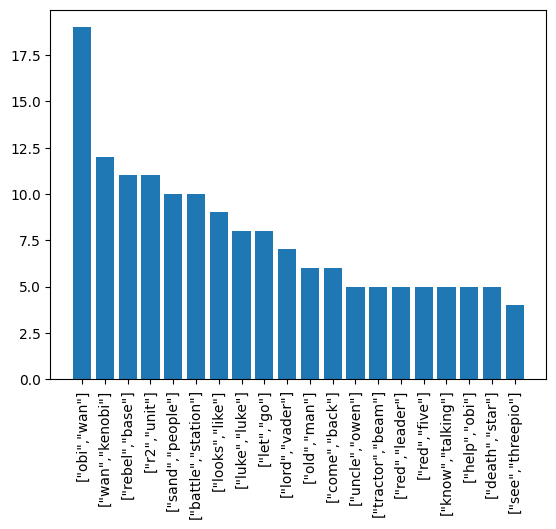

In [337]:
import matplotlib.pyplot as plt

plt.bar(x=data_to_diag.keys(), 
        height=data_to_diag.values(), 
        width=0.8)
plt.xticks(rotation=90);

Эпизод V

In [338]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeV.txt > output_3_2.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.110619.830373
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.110619.830373/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.110619.830373/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.110619.830373...


In [339]:
with open('/kaggle/working/output_3_2.txt') as file:
    data = [line.rstrip() for line in file]

In [340]:
data_to_diag = dict()

for sample in data:
    value, char = sample.split('\t')
    data_to_diag[char] = int(value)

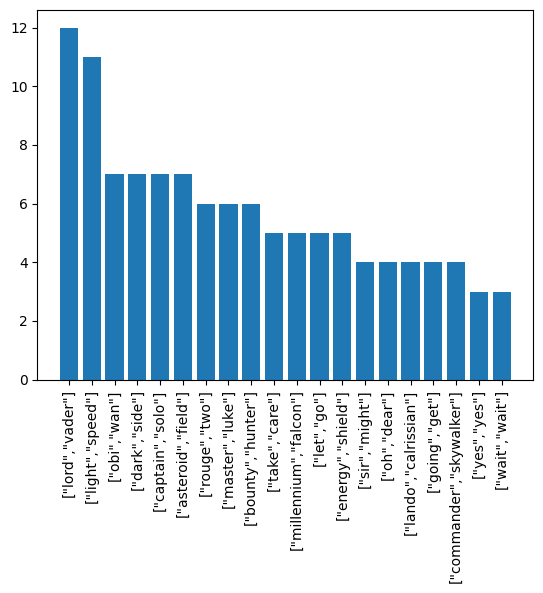

In [341]:
import matplotlib.pyplot as plt

plt.bar(x=data_to_diag.keys(), 
        height=data_to_diag.values(), 
        width=0.8)
plt.xticks(rotation=90);

Эпизод VI

In [342]:
!python3 chars_phrases_count.py /kaggle/input/star-wars-movie-scripts/SW_EpisodeVI.txt > output_3_3.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.110724.332171
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.110724.332171/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.110724.332171/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.110724.332171...


In [343]:
with open('/kaggle/working/output_3_3.txt') as file:
    data = [line.rstrip() for line in file]

In [344]:
data_to_diag = dict()

for sample in data:
    value, char = sample.split('\t')
    data_to_diag[char] = int(value)

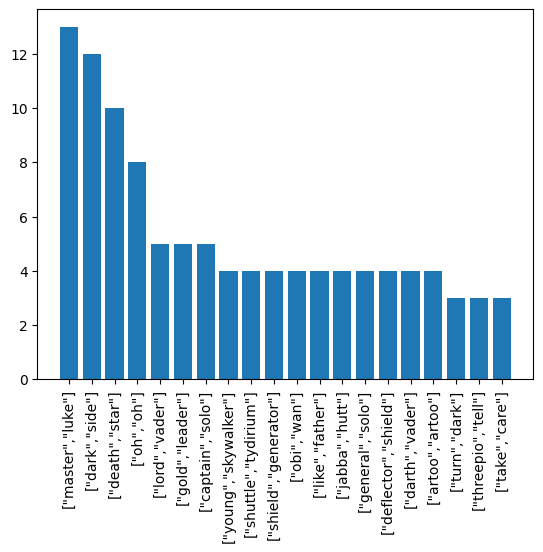

In [345]:
import matplotlib.pyplot as plt

plt.bar(x=data_to_diag.keys(), 
        height=data_to_diag.values(), 
        width=0.8)
plt.xticks(rotation=90);

Все эпизоды

In [346]:
!python3 chars_phrases_count.py /kaggle/working/input.txt > output_3_4.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/chars_phrases_count.root.20231125.110833.209297
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/chars_phrases_count.root.20231125.110833.209297/output
Streaming final output from /tmp/chars_phrases_count.root.20231125.110833.209297/output...
Removing temp directory /tmp/chars_phrases_count.root.20231125.110833.209297...


In [347]:
with open('/kaggle/working/output_3_4.txt') as file:
    data = [line.rstrip() for line in file]

In [348]:
data_to_diag = dict()

for sample in data:
    value, char = sample.split('\t')
    data_to_diag[char] = int(value)

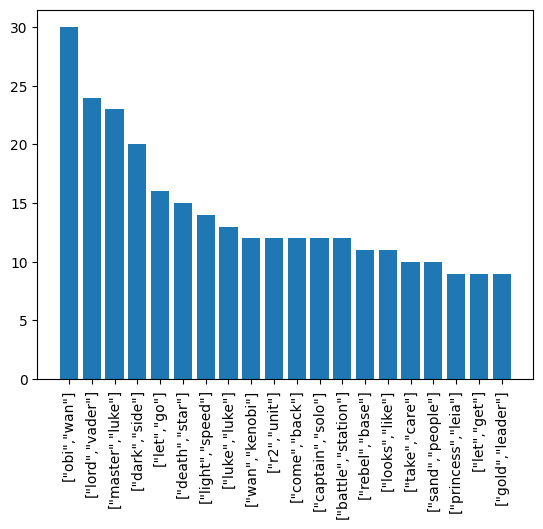

In [349]:
import matplotlib.pyplot as plt

plt.bar(x=data_to_diag.keys(), 
        height=data_to_diag.values(), 
        width=0.8)
plt.xticks(rotation=90);